In [1]:
from typing import List

import igraph
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pynauty
from scipy.sparse.linalg import expm_multiply
from sympy.combinatorics import Permutation, PermutationGroup

from qlinks.computation_basis import ComputationBasis
from qlinks.lattice.square_lattice import SquareLattice
from qlinks.model.quantum_link_model import QuantumLinkModel
from qlinks.symmetry.automorphism import Automorphism
from qlinks.symmetry.gauss_law import GaussLaw
from qlinks.visualizer.basis import BasisVisualizer

np.set_printoptions(threshold=np.inf)
pd.set_option("display.max_rows", None)

In [6]:
def format_custom_index(index):
    return [f"({i}) {idx}" for i, idx in enumerate(index)]


def setup_model(model_name, lattice_shape, coup_j, coup_rk):
    gauss_law = {
        "qlm": GaussLaw.from_zero_charge_distri,
        "qdm": GaussLaw.from_staggered_charge_distri,
    }[model_name](*lattice_shape, flux_sector=(0, 0))
    basis = gauss_law.solve()
    model = QuantumLinkModel(coup_j, coup_rk, lattice_shape, basis)
    return basis, model


def setup_igraph(nx_g, highlight: List[int] = None, highlight_color: List[str] = None):
    ig = igraph.Graph.from_networkx(nx_g)
    ig.vs["label"] = [str(i) for i in range(ig.vcount())]
    color = ["whitesmoke" for _ in range(ig.vcount())]
    if highlight is not None:
        for i, nodes in enumerate(highlight):
            for node in nodes:
                color[node] = highlight_color[i]
        ig.vs["color"] = color
    return ig

# Quantum Link/Dimer Model

In [7]:
coup_j, coup_rk = (1, -0.1)
basis, model = setup_model(
    "qlm", lattice_shape=(4, 4), coup_j=coup_j, coup_rk=coup_rk
)
evals, evecs = np.linalg.eigh(model.hamiltonian.toarray())

2024-06-16 17:09:38 [constraint_programming.py] INFO: CpSolverResponse summary:
status: OPTIMAL
objective: 0
best_bound: 0
integers: 32
booleans: 32
conflicts: 609
branches: 24393
propagations: 88345
integer_propagations: 108550
restarts: 3014
lp_iterations: 5436
walltime: 0.345281
usertime: 0.345281
deterministic_time: 0.121793
gap_integral: 0
solution_fingerprint: 0x1cb2e4843e05e07a

2024-06-16 17:09:38 [constraint_programming.py] INFO: Found 990 optimal solutions.


In [ ]:
# basis.dataframe.to_parquet("qdm_8x4_lattice.parquet", index=False)
basis = ComputationBasis.from_parquet("data/qdm_8x4_lattice.parquet")
coup_j, coup_rk = (1, 0)
model = QuantumLinkModel(coup_j, coup_rk, (8, 4), basis)

In [ ]:
evals, evecs = np.load("data/qdm_8x4_coup_j_1_coup_rk_0_eigs.npz").values()

In [ ]:
df = basis.dataframe.copy(deep=True)
df.index = format_custom_index(df.index)
df

In [4]:
# evecs_df = pd.read_parquet("data/qdm_8x4_coup_j_1_coup_rk_0_eigs.parquet")
evecs_df = pd.DataFrame.from_dict(
    {
        "eval": evals,
        "kin": [(evec.T @ model.kinetic_term @ evec).item() for evec in evecs.T],
        "pot": [(evec.T @ model.potential_term @ evec).item() for evec in evecs.T],
        "kin^2": [(evec.T @ model.kinetic_term @ model.kinetic_term @ evec).item() for evec in evecs.T],
        "pot^2": [(evec.T @ model.potential_term @ model.potential_term @ evec).item() for evec in evecs.T],
    }
)
evecs_df[evecs_df["kin"].abs() < 1e-12]

,eval,kin,pot,kin^2,pot^2
5,-0.4,-4.622232e-32,4.0,8.874685e-31,16.0
6,-0.3,2.465190e-31,3.0,3.451266e-31,9.0
7,-0.3,0.000000e+00,3.0,1.232595e-31,9.0
8,-0.3,-9.860761e-32,3.0,4.437343e-31,9.0


In [ ]:
evecs_df[(evecs_df["kin"].abs() - 2).abs() < 1e-12]

In [ ]:
plt.plot(evecs[:, 39].T, linestyle="--", marker="o", color="red")
plt.grid()

In [ ]:
entropies = np.asarray([model.entropy(evecs[:, i], 2, 0) for i in range(basis.n_states)])
entropy_df = pd.Series(entropies, name="entropy")
entropy_df[entropy_df < 1.9]
# entropy_df.plot(style="o", grid=True)

In [8]:
aut = Automorphism(-model.kinetic_term)
aut.joint_partition.keys()

dict_keys([(2, 'A'), (4, 'A'), (5, 'A'), (6, 'B'), (8, 'A'), (8, 'B'), (9, 'B'), (10, 'A'), (12, 'B'), (16, 'A')])

In [21]:
aut.type_1_scars((8, 'A'))[0]

array([[-9.96746288e-17,  1.44907851e-16,  0.00000000e+00,
        -7.71512061e-18, -1.32763873e-15,  0.00000000e+00,
         0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.98551830e-16,  0.00000000e+00,
         0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.42693894e-01, -2.54090917e-02,  1.77054585e-02,
        -6.17560967e-02,  2.27845574e-01, -3.52761817e-02,
         4.17579610e-02,  8.88659255e-02,  1.58111388e-01,
        -9.64283772e-02, -7.14661620e-02, -3.89785327e-02,
        -1.06274498e-03,  8.74927578e-02, -5.72930179e-02,
        -4.07892868e-02,  9.99460701e-02,  2.33778216e-02,
        -1.14137224e-01,  4.05402164e-02],
       [-1.01234974e-01,  5.11418049e-02, -5.19415178e-03,
        -2.79886509e-02, -3.72865252e-01, -1.03656598e-02,
         2.17385314e-02,  1.96210056e-02,  1.25193181e-02,
        -1.49067182e-04,  7.5

In [23]:
aut.type_3a_scars(8)[0]

2024-06-16 17:15:46 [automorphism.py] INFO: eval: -2.0, num of scars: 3
2024-06-16 17:15:46 [automorphism.py] INFO: eval: 2.0, num of scars: 3
2024-06-16 17:15:46 [automorphism.py] INFO: eval: -2.0, num of scars: 3
2024-06-16 17:15:46 [automorphism.py] INFO: eval: 2.0, num of scars: 3


array([[-8.84815822e-15,  0.00000000e+00,  1.76776695e-01],
       [ 1.43393043e-01, -5.36277478e-02,  8.83883476e-02],
       [-1.43393043e-01,  5.36277478e-02,  8.83883476e-02],
       [ 9.12346227e-15, -2.87964097e-16, -1.76776695e-01],
       [-9.83584064e-02, -1.17316341e-01, -8.83883476e-02],
       [ 9.83584064e-02,  1.17316341e-01, -8.83883476e-02],
       [ 7.34745146e-16, -4.68375339e-16, -3.33066907e-16],
       [ 4.50346362e-02, -1.70944089e-01,  2.47024623e-15],
       [-4.50346362e-02,  1.70944089e-01, -2.02615702e-15],
       [-3.52358713e-16,  7.63278329e-17, -1.11022302e-16],
       [ 1.43393043e-01, -5.36277478e-02, -8.83883476e-02],
       [-1.43393043e-01,  5.36277478e-02, -8.83883476e-02],
       [ 8.96699043e-15, -1.90819582e-17, -1.76776695e-01],
       [-8.75513799e-15, -1.90819582e-17,  1.76776695e-01],
       [ 1.43393043e-01, -5.36277478e-02,  8.83883476e-02],
       [-1.43393043e-01,  5.36277478e-02,  8.83883476e-02],
       [ 4.50346362e-02, -1.70944089e-01

In [24]:
g = nx.from_scipy_sparse_array(-model.kinetic_term)
ig = igraph.Graph.from_networkx(g)

ntg = pynauty.Graph(
    ig.vcount(),
    directed=True,
    adjacency_dict=nx.to_dict_of_lists(g),
)
aut_gp = pynauty.autgrp(ntg)[0]

perm_gp = PermutationGroup([Permutation(p) for p in aut_gp])

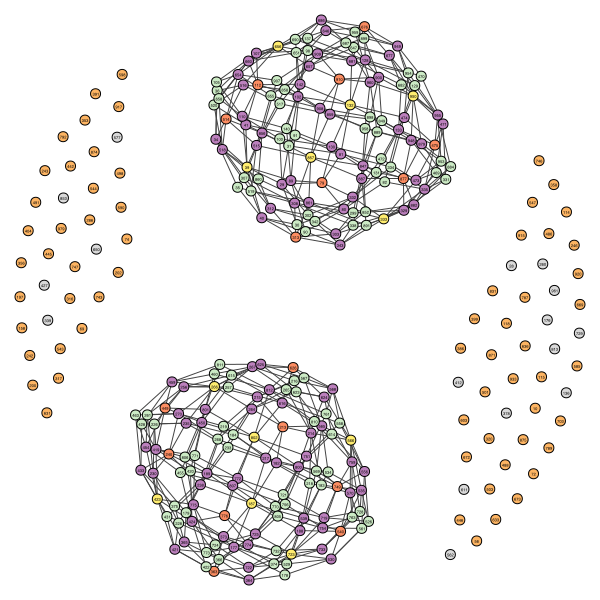

In [34]:
g = nx.from_scipy_sparse_array(-model.kinetic_term)

# highlight = [
#     np.where(np.abs(evecs[:, 3]) > 0.0001)[0],
# ]
# highlight = group_indices_by_value(dict(g.degree))
highlight = perm_gp.orbits()
# highlight = list(nx.bipartite.sets(g))

# highlight_color = list(mcolors.TABLEAU_COLORS.values())
# highlight_color = list(mcolors.CSS4_COLORS.values())
cmap = plt.get_cmap('Set3')
highlight_color = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
cmap = plt.get_cmap('Set2')
highlight_color += [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
# highlight_color = [
#     "dimgray",
#     "whitesmoke",
#     "deepskyblue",
#     "yellowgreen",
#     "aqua",
#     "pink",
#     "tomato",
#     "royalblue",
#     "blueviolet",
#     "cornflowerblue",
#     "limegreen",
# ]

ig = setup_igraph(g, highlight, highlight_color)

degree = np.array(list(dict(g.degree).values()))
# (bipartite, types) = ig.is_bipartite(return_types=True)
# nodes = [int(n) for n in list(sub_sub_ig.vs["label"])]
# outer_boundary = list(nx.node_boundary(g, nodes))
# sub_ig = ig.induced_subgraph(np.append(nodes, outer_boundary))

sub_ig = ig.induced_subgraph(np.where(degree == 8)[0])
# fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")
igraph.plot(
    sub_ig,
    # layout=ig.layout_kamada_kawai(),
    # layout=ig.layout_reingold_tilford(root=[0, 25, 50, 75]),
    # layout=ig.layout_bipartite(types=types),
    vertex_size=10,
    vertex_label_size=4,
    # edge_width=0.4,
    # edge_color="darkgray",
    # target="qdm_graph_4x2.svg"
)

In [ ]:
sub_components = sub_ig.connected_components(mode="weak")

for i, c in enumerate(sub_components):
    mat = nx.to_numpy_array(sub_ig.subgraph(c).to_networkx())
    print(i, mat.shape[0], mat.shape[0] - np.linalg.matrix_rank(mat))

In [ ]:
degree = np.array(list(dict(g.degree).values()))

plt.plot(np.sort(degree), linestyle="--", marker="o")
plt.grid()
plt.show()

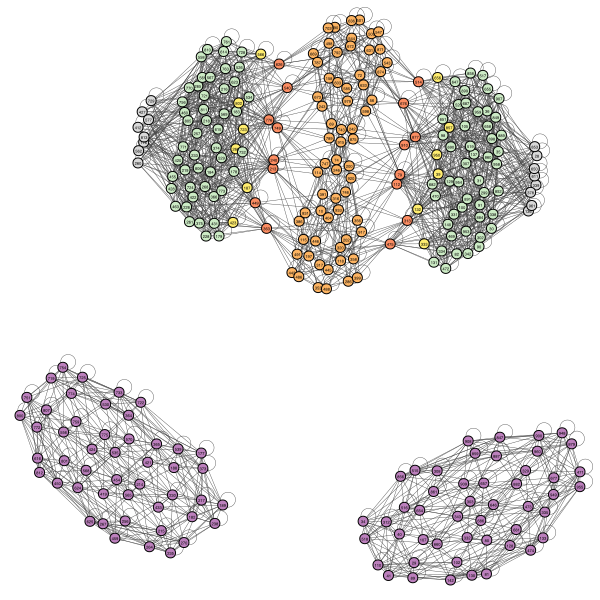

In [37]:
two_steps_mat = model.kinetic_term @ model.kinetic_term
g = nx.from_numpy_array(two_steps_mat)

# highlight = [
#     np.where(np.abs(evecs[:, 3]) > 0.0001)[0],
# ]
# highlight = group_indices_by_value(dict(g.degree))
highlight = perm_gp.orbits()
# highlight = list(nx.bipartite.sets(g))

# highlight_color = list(mcolors.TABLEAU_COLORS.values())
# highlight_color = list(mcolors.CSS4_COLORS.values())
cmap = plt.get_cmap('Set3')
highlight_color = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
cmap = plt.get_cmap('Set2')
highlight_color += [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
# highlight_color = [
#     "dimgray",
#     "whitesmoke",
#     "deepskyblue",
#     "yellowgreen",
#     "aqua",
#     "pink",
#     "tomato",
#     "royalblue",
#     "blueviolet",
#     "cornflowerblue",
#     "limegreen",
# ]

ig = setup_igraph(g, highlight, highlight_color)

sub_ig = ig.induced_subgraph(np.where(degree == 8)[0])
# fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")
igraph.plot(
    sub_ig,
    layout=sub_ig.layout_kamada_kawai(),
    # layout=ig.layout_bipartite(types=types),
    vertex_size=10,
    vertex_label_size=4,
    edge_width=0.4,
    # edge_color="darkgray",
    # target="qdm_graph_4x2.svg"
)

In [38]:
sub_components = sub_ig.connected_components(mode="weak")

for i, c in enumerate(sub_components):
    mat = nx.to_numpy_array(sub_ig.subgraph(c).to_networkx())
    print(i, mat.shape[0], mat.shape[0] - np.linalg.matrix_rank(mat))

0 204 20
1 48 3
2 48 3


In [49]:
sub_sub_ig = sub_ig.subgraph(sub_components[0])

evals, evecs = np.linalg.eigh(nx.to_numpy_array(sub_sub_ig.to_networkx()))

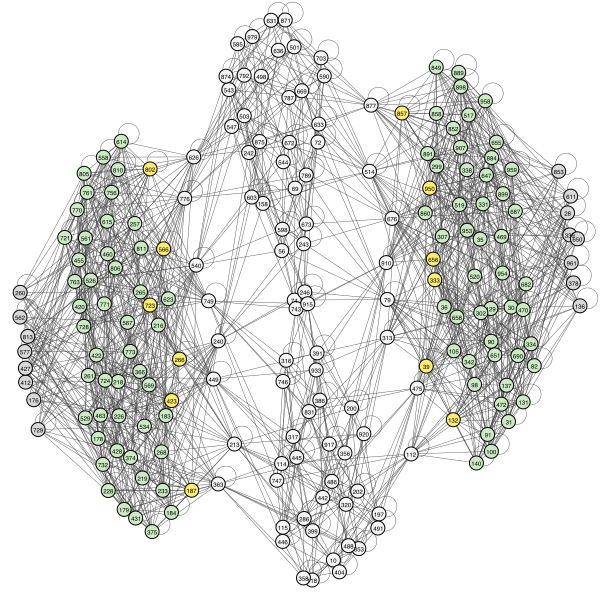

In [50]:
highlight = [np.where(np.abs(evecs[:, 0]) < 0.0001)[0]]

color = sub_sub_ig.vs["color"]
for i, nodes in enumerate(highlight):
    for node in nodes:
        color[node] = "whitesmoke"
sub_sub_ig.vs["color"] = color

igraph.plot(
    sub_sub_ig,
    layout=sub_sub_ig.layout_kamada_kawai(),
    vertex_size=14,
    vertex_label_size=6,
    edge_width=0.4,
    # edge_color="darkgray",
    # target="qdm_graph_4x2.svg"
)

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(32, 24), facecolor="white")
ax = axes.flatten()

for i, val in enumerate(np.where(np.abs(evecs[:, 77]) > 0.1)[0][:16]):
    g = BasisVisualizer(SquareLattice(*model.shape, basis.dataframe.iloc[val]))
    g.plot(show=False, ax=ax[i], node_size=800)
    ax[i].set_title(f"{df.index[val]}")

In [ ]:
g = BasisVisualizer(SquareLattice(*model.shape, basis.dataframe.iloc[7]))
g.plot(show=False, node_size=800)
plt.title(f"{df.index[7]}", fontsize=16)
plt.tight_layout()
plt.savefig("qdm_basis_4x4.svg", format="svg")

In [ ]:
coup_j = np.ones((np.prod(model.shape), 1))
coup_j[3] = 1.2
energy_lump_model = QuantumLinkModel(coup_j, coup_rk, model.shape, basis)
energy_lump_ham = energy_lump_model.hamiltonian

# scar_state = np.zeros((basis.n_states, 1))
# scar_state[np.array([25, 26, 67, 68]), 0] = np.array([1, -1, -1, 1])
# scar_state /= np.linalg.norm(scar_state)
scar_state = evecs[:, 78]

start, stop, num = 0, 400, 100
evol_states = expm_multiply(-1j * energy_lump_ham, scar_state, start=start, stop=stop, num=num)
fidelity = [np.abs(evol_state.T @ scar_state).item() ** 2 for evol_state in evol_states]
rate_func = [-np.log(evol_state.T @ scar_state).item() for evol_state in evol_states]
entropy = [model.entropy(evol_state.flatten(), 2, 0) for evol_state in evol_states]

plt.plot(np.linspace(start, stop, num), fidelity, linestyle="--", marker="o")
plt.ylim(0.0001, 1.1)
# plt.yscale('log')
plt.xlabel("t")
plt.ylabel("Fidelity(t)")
plt.tight_layout()
plt.show()

plt.plot(np.linspace(start, stop, num), rate_func, linestyle="--", marker="o")
# plt.yscale('log')
plt.xlabel("t")
plt.ylabel("rate_func(t)")
plt.tight_layout()
plt.show()

plt.plot(np.linspace(start, stop, num), np.round(entropy, 12), linestyle="--", marker="o")
plt.xlabel("t")
plt.ylabel("EE(t)")
plt.tight_layout()
plt.show()

final_state = np.real_if_close(evol_states[-1], tol=1e-12)
print(f"final fidelity = {fidelity[-1]}")
print(f"O_kin @ psi_scar = {(model.kinetic_term @ final_state).flatten()}")
print(f"<O_kin> = {(final_state.T @ model.kinetic_term @ final_state).item()}")
print(f"<O_pot> = {(final_state.T @ model.potential_term @ final_state).item()}")
print(f"<H> = {(final_state.T @ model.hamiltonian @ final_state).item()}")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")
ax.set_prop_cycle(color=plt.cm.tab20(np.linspace(0, 1, 3)), marker=["o", "^", "d"])

for i, epsilon in enumerate([0.05, 0.1, 0.15]):
    coup_j = np.ones((np.prod(model.shape), 1))
    coup_j[5] += epsilon
    energy_lump_model = QuantumLinkModel(coup_j, coup_rk, model.shape, basis)
    energy_lump_ham = energy_lump_model.hamiltonian

    scar_state = np.zeros((basis.n_states, 1))
    scar_state[np.array([25, 26, 67, 68]), 0] = np.array([1, -1, -1, 1])
    scar_state /= np.linalg.norm(scar_state)
    # scar_state = evecs[:, 77]

    start, stop, num = 0, 400, 100
    evol_states = expm_multiply(-1j * energy_lump_ham, scar_state, start=start, stop=stop, num=num)
    # fidelity = [np.abs(evol_state.T @ scar_state).item() ** 2 for evol_state in evol_states]
    rate_func = [-np.log(evol_state.T @ scar_state).item() for evol_state in evol_states]
    # entropy = [model.entropy(evol_state.flatten(), 1, 0) for evol_state in evol_states]

    # ax.plot(np.linspace(start, stop, num), fidelity, linestyle="--")
    # ax.plot(np.linspace(start, stop, num), np.round(entropy, 12), linestyle="--")
    ax.plot(np.linspace(start, stop, num), rate_func, linestyle="--")

ax.legend([f"epsilon = {epsilon}" for epsilon in [0.05, 0.1, 0.15]], fontsize=16, loc="upper right")
# plt.ylim(0.0001, 1.1)
plt.title("QDM 4x4", fontsize=18)
plt.xlabel("t", fontsize=18)
plt.ylabel("Rate_Func(t)", fontsize=18)
plt.tight_layout()

In [ ]:
import pyvis.network as nt

net = nt.Network(filter_menu=True, select_menu=True, font_color="black")
net.from_nx(g)
for node in net.nodes:
    node["title"] = str(node["id"])
net.show_buttons(filter_=["nodes", "edges", "physics"])
net.write_html("nx.html")

In [ ]:
import matplotlib.ticker as ticker

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 18
})

fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")
ax.hist(evals, bins="auto", density=True, alpha=0.7, color='royalblue', edgecolor='darkgray')
ax.set_ylabel(r"$\rho(E)$")
ax.set_xlabel(r"$E$")
ax.xaxis.set_major_locator(ticker.MultipleLocator(2.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.025))
# plt.grid()
plt.savefig("qdm_8x4_kin_dos.svg", dpi=300, format="svg")